In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lamiasaraoui","key":"d0f7cc0db09604706a0e76f77077ab91"}'}

In [2]:
!mkdir -p ~/.kaggle

In [3]:
cp "kaggle.json" ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 99% 325M/329M [00:01<00:00, 289MB/s]
100% 329M/329M [00:01<00:00, 268MB/s]


In [6]:
! unzip /content/plant-village.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tom

In [7]:
! rm /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c

In [8]:
import os
# Define the path to remove
path_to_remove = "/content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c"

# Remove the file or directory
if os.path.exists(path_to_remove):
    if os.path.isdir(path_to_remove):
        shutil.rmtree(path_to_remove)
        print(f"Directory {path_to_remove} has been removed.")
    else:
        os.remove(path_to_remove)
        print(f"File {path_to_remove} has been removed.")
else:
    print(f"Path {path_to_remove} does not exist.")

Path /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c does not exist.


In [9]:
!ls /content/PlantVillage

Pepper__bell___Bacterial_spot  Tomato_Bacterial_spot  Tomato_Septoria_leaf_spot
Pepper__bell___healthy	       Tomato_Early_blight    Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Early_blight	       Tomato_healthy	      Tomato__Target_Spot
Potato___healthy	       Tomato_Late_blight     Tomato__Tomato_mosaic_virus
Potato___Late_blight	       Tomato_Leaf_Mold       Tomato__Tomato_YellowLeaf__Curl_Virus


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import files

In [11]:
# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = 224  # MobileNetV2 default size
CHANNELS = 3
EPOCHS = 10

In [12]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [13]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [14]:
len(class_names)

15

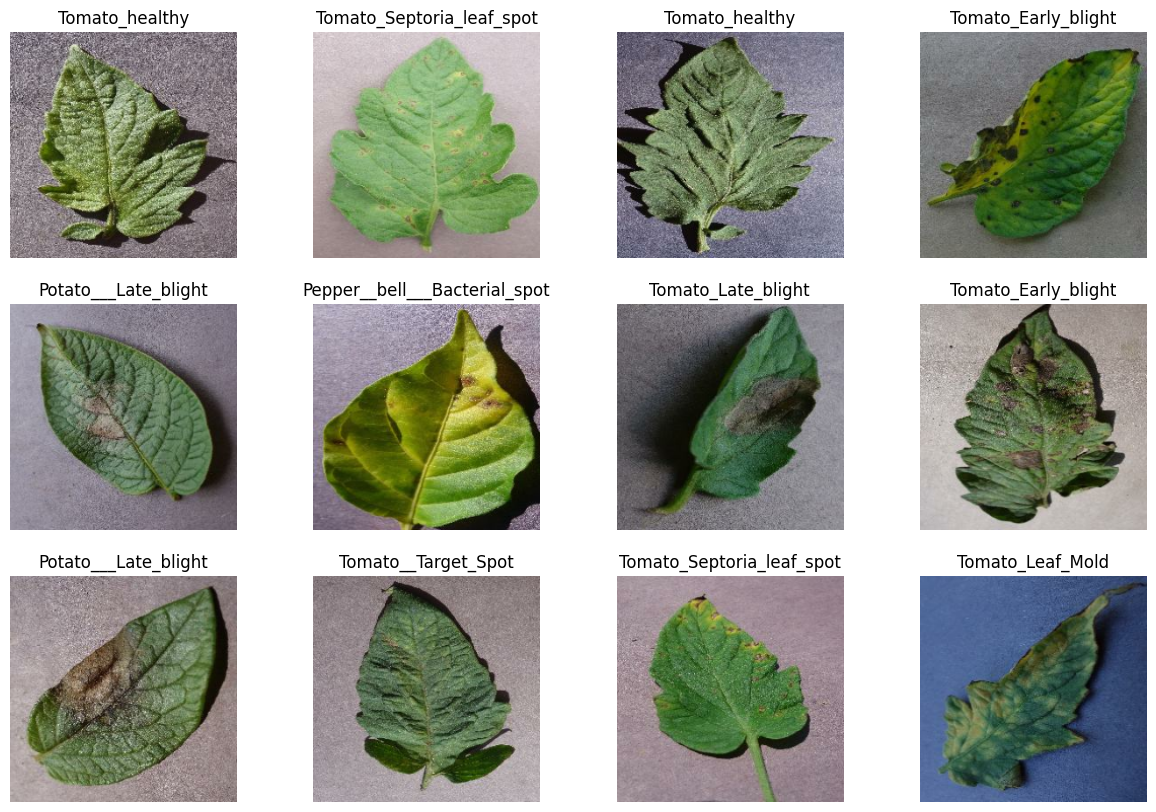

In [15]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
# Function to partition dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
# Apply resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [19]:
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [20]:
# Define data augmentation
augmentation_layers_list = ([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontally and vertically
    layers.RandomRotation(0.2),                    # Rotate by up to 20%
    layers.RandomTranslation(0.1, 0.1),            # Translate by up to 10% horizontally and vertically
    layers.RandomZoom(0.2, 0.2),                   # Zoom in/out by up to 20%
    layers.RandomBrightness(factor=0.2),           # Adjust brightness by +/- 20%
    layers.RandomContrast(factor=0.2),             # Adjust contrast by +/- 20%
    layers.GaussianNoise(0.1),                     # Add Gaussian noise
    layers.RandomCrop(256, 256),                   # Randomly crop to 256x256 (if needed)
    layers.Rescaling(1./255)                       # Normalize to [0,1] range,
])

In [21]:
# Sequential model for applying the augmentations
augmentation_layers = tf.keras.Sequential(augmentation_layers_list)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

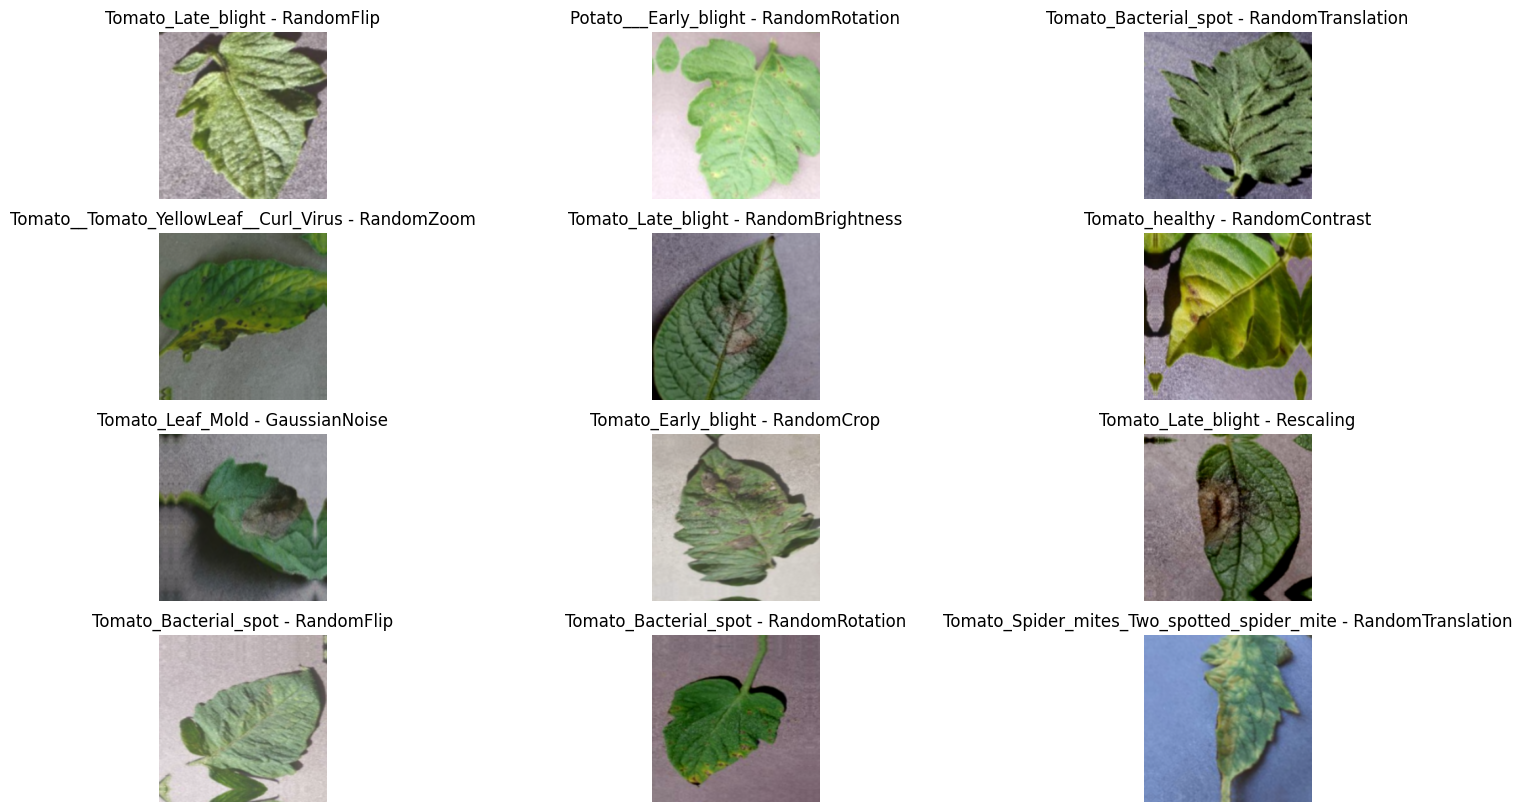

In [22]:
plt.figure(figsize=(18, 10))
for images, labels in dataset.take(1):
  for i in range(12):
    augmented_image = augmentation_layers(image_batch[i].numpy().astype("uint8"))
    ax = plt.subplot(4, 3, i + 1)
    label = class_names[labels[i]]
    augmentation_layer = augmentation_layers_list[i % len(augmentation_layers_list)]
    plt.imshow(augmented_image.numpy())
    plt.title(f"{label} - {augmentation_layer.__class__.__name__}")
    plt.axis("off")
plt.savefig("augmented_images.png")
files.download("augmented_images.png")

In [23]:
# Function to apply a single augmentation layer
def apply_augmentation(image, layer):
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.cast(image, tf.float32)  # Convert image to float32
    augmented_image = layer(image, training=True)
    return tf.squeeze(augmented_image, axis=0)  # Remove batch dimension

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [25]:
def build_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [26]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)

model = build_model(input_shape, num_classes)

9406464/9406464 [==============================] - 0s 0us/step


In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/10
516/516 [==============================] - 124s 230ms/step - loss: 1.0578 - accuracy: 0.6584 - val_loss: 0.4557 - val_accuracy: 0.8652
Epoch 2/10
516/516 [==============================] - 113s 218ms/step - loss: 0.6185 - accuracy: 0.7943 - val_loss: 0.3420 - val_accuracy: 0.8843
Epoch 3/10
516/516 [==============================] - 115s 224ms/step - loss: 0.5299 - accuracy: 0.8221 - val_loss: 0.3288 - val_accuracy: 0.8921
Epoch 4/10
516/516 [==============================] - 114s 221ms/step - loss: 0.4708 - accuracy: 0.8418 - val_loss: 0.2551 - val_accuracy: 0.9155
Epoch 5/10
516/516 [==============================] - 114s 222ms/step - loss: 0.4430 - accuracy: 0.8519 - val_loss: 0.2461 - val_accuracy: 0.9189
Epoch 6/10
516/516 [==============================] - 117s 226ms/step - loss: 0.4182 - accuracy: 0.8591 - val_loss: 0.2237 - val_accuracy: 0.9253
Epoch 7/10
516/516 [==============================] - 116s 226ms/step - loss: 0.4000 - accuracy: 0.8625 - val_loss: 0.2140 -

In [30]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc * 100:.2f}%")

65/65 [==============================] - 14s 194ms/step - loss: 0.1517 - accuracy: 0.9500
Test accuracy: 95.00%


In [31]:
scores2 = model.evaluate(val_ds)

64/64 [==============================] - 13s 196ms/step - loss: 0.1743 - accuracy: 0.9414


In [32]:
# Save the model
model.save('mobilenetv2_plant_disease.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


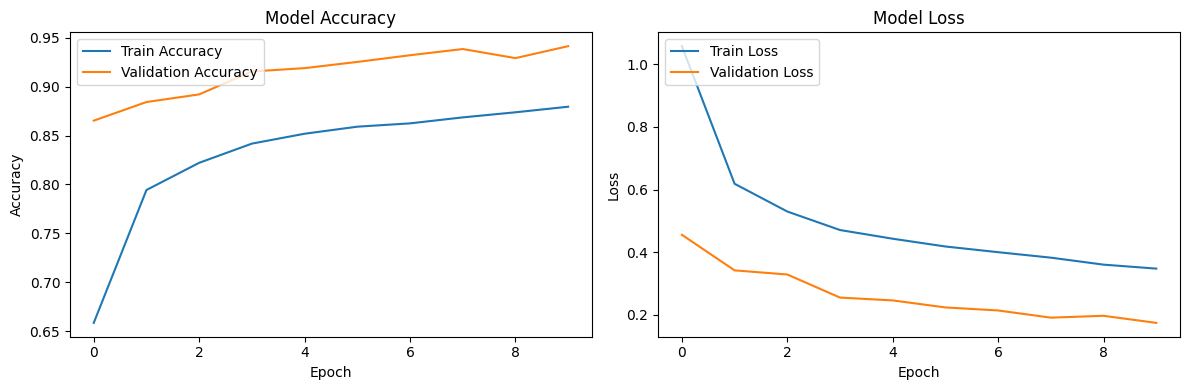

Final Training Accuracy: 0.8795
Final Validation Accuracy: 0.9414
Final Training Loss: 0.3476
Final Validation Loss: 0.1743
No overfitting detected: Model generalizes well to validation data.


In [33]:
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    # Check for overfitting
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")
    print(f"Final Training Loss: {train_loss:.4f}")
    print(f"Final Validation Loss: {val_loss:.4f}")

    if train_acc > val_acc and (train_acc - val_acc) > 0.1:
        print("Potential overfitting detected: Training accuracy is significantly higher than validation accuracy.")
    if train_loss < val_loss and (val_loss - train_loss) > 0.1:
        print("Potential overfitting detected: Training loss is significantly lower than validation loss.")

    # You can further analyze trends to confirm overfitting.
    if all([val_acc < acc for acc in history.history['accuracy'][-3:]]):
        print("Validation accuracy is not improving over last epochs, indicating potential overfitting.")


        # Check for overfitting
    acc_diff = np.array(history.history['accuracy']) - np.array(history.history['val_accuracy'])
    loss_diff = np.array(history.history['loss']) - np.array(history.history['val_loss'])

    overfitting_detected = np.any(acc_diff > 0.1) or np.any(loss_diff < -0.1)
    if overfitting_detected:
        print("Overfitting detected: Training accuracy significantly higher than validation accuracy, or validation loss is increasing.")
    else:
        print("No overfitting detected: Model generalizes well to validation data.")

plot_metrics(history)

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [35]:
# Prédire les classes pour l'ensemble de test
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 0s 239ms/step


In [36]:
# Construire la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

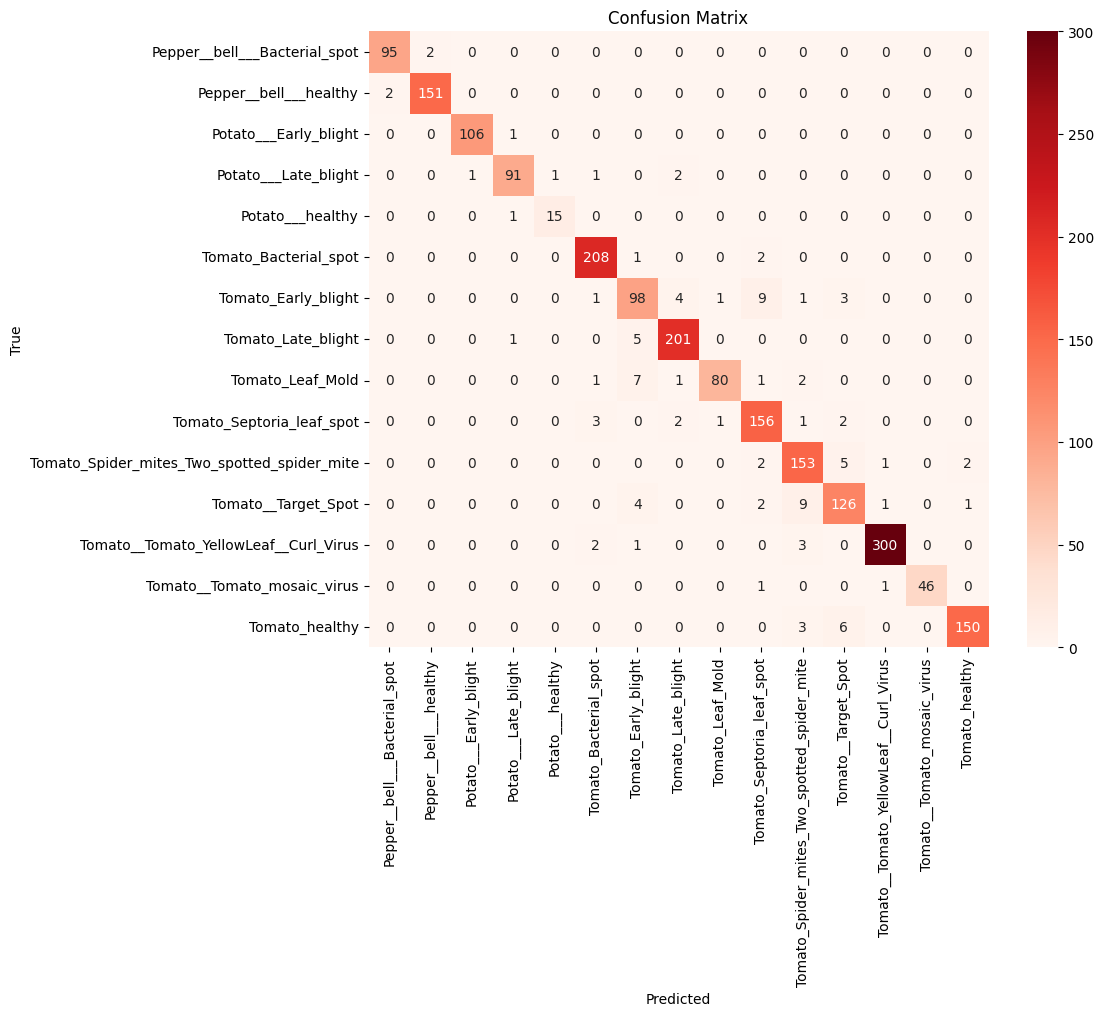

In [37]:
# Afficher la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Afficher le rapport de classification
print(classification_report(y_true, y_pred, target_names=class_names))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.98      0.98        97
                     Pepper__bell___healthy       0.99      0.99      0.99       153
                      Potato___Early_blight       0.99      0.99      0.99       107
                       Potato___Late_blight       0.97      0.95      0.96        96
                           Potato___healthy       0.94      0.94      0.94        16
                      Tomato_Bacterial_spot       0.96      0.99      0.97       211
                        Tomato_Early_blight       0.84      0.84      0.84       117
                         Tomato_Late_blight       0.96      0.97      0.96       207
                           Tomato_Leaf_Mold       0.98      0.87      0.92        92
                  Tomato_Septoria_leaf_spot       0.90      0.95      0.92       165
Tomato_Spider_mites_Two_spotted_spider_mite       0.89      0.94

1/1 [==============================] - 0s 45ms/step


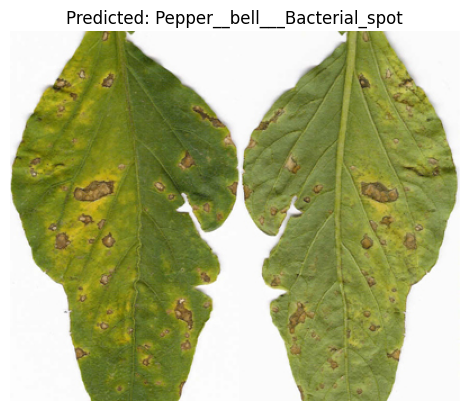

In [41]:
from tensorflow.keras.preprocessing import image

# Define a function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale
    return img_array

# Load a sample image
img_path = '/content/Pepper bell Bacterial spot.jpg'
img_array = preprocess_image(img_path, target_size=(224, 224))

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Visualize the prediction
plt.imshow(image.load_img(img_path))
plt.title(f"Predicted: {class_names[predicted_class[0]]}")
plt.axis('off')
plt.show()

In [42]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.8 MB/s eta 0:00:00


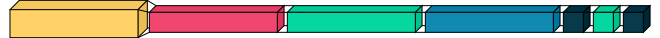

In [43]:
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [44]:
!pip install keras_sequential_ascii

  Preparing metadata (setup.py) ... done
  Created wheel for keras_sequential_ascii: filename=keras_sequential_ascii-0.1.1-py3-none-any.whl size=3042 sha256=c02a438c78fff3c77b6c060171ccb0eeff2c1f8a803a62f2c10f626a012b4d2e
  Stored in directory: /root/.cache/pip/wheels/50/10/f3/5eeae758ef81ee4e16d618471561509355b0f2e5f38bf41185
Successfully built keras_sequential_ascii


In [45]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####    224  224    3
          Functional   ????? -------------------   2257984    93.2%
                       #####      7    7 1280
GlobalAveragePooling2D   Y^avg -------------------         0     0.0%
                       #####        1280
             Dropout    | || -------------------         0     0.0%
                       #####        1280
             Flatten   ||||| -------------------         0     0.0%
                       #####        1280
               Dense   XXXXX -------------------    163968     6.8%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------      1935     0.1%
             softmax   #####          15


In [46]:
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Définir un répertoire pour les logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
516/516 [==============================] - 129s 249ms/step - loss: 0.3461 - accuracy: 0.8824 - val_loss: 0.1790 - val_accuracy: 0.9429
Epoch 2/10
516/516 [==============================] - 125s 242ms/step - loss: 0.3490 - accuracy: 0.8797 - val_loss: 0.1619 - val_accuracy: 0.9463
Epoch 3/10
516/516 [==============================] - 126s 244ms/step - loss: 0.3240 - accuracy: 0.8877 - val_loss: 0.1477 - val_accuracy: 0.9531
Epoch 4/10
516/516 [==============================] - 125s 243ms/step - loss: 0.3172 - accuracy: 0.8903 - val_loss: 0.1445 - val_accuracy: 0.9546
Epoch 5/10
516/516 [==============================] - 126s 244ms/step - loss: 0.3088 - accuracy: 0.8904 - val_loss: 0.1385 - val_accuracy: 0.9536
Epoch 6/10
516/516 [==============================] - 123s 238ms/step - loss: 0.3087 - accuracy: 0.8912 - val_loss: 0.1400 - val_accuracy: 0.9482
Epoch 7/10
431/516 [========================>.....] - ETA: 17s - loss: 0.3075 - accuracy: 0.8919

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
# Sélectionner une couche intermédiaire
layer_name = 'global_average_pooling2d'
intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                                 outputs=model.get_layer(layer_name).output)

# Obtenir les activations pour un lot d'images
for images, labels in test_ds.take(1):
    intermediate_output = intermediate_layer_model(images)

# Réduction de dimension avec PCA ou t-SNE
pca = PCA(n_components=3)
tsne = TSNE(n_components=3)

pca_result = pca.fit_transform(intermediate_output)
tsne_result = tsne.fit_transform(intermediate_output)

# Visualisation 3D avec matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# PCA
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=labels, cmap='viridis')
ax1.set_title('PCA Projection')

# t-SNE
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c=labels, cmap='viridis')
ax2.set_title('t-SNE Projection')

plt.show()